In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

# Load mono scan

In [3]:
fc = FileChooser('/sf/alvra/data/p18955/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18955/raw', filename='', show_hidden='False')

In [4]:
Timezero_mm = 189.85067 # position of Timezero on PP delay (in mm!)
Timezero_fs = Timezero_mm *2/(3e8*1e3*1e-15)

quantile_corr = 1.0

channel_list = [channel_APD_Ch1, channel_APD_Ch2, channel_Izero117, channel_delay_harm]# channel_energy]

########################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = np.asarray(scan.readbacks)# - Timezero_fs

DataFluo = []
DataFluo2 = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    results = load_data_compact(channel_list, step)[0]
    
    DataFluo_shot = results[channel_APD_Ch1]
    DataFluo2_shot = results[channel_APD_Ch2]
    IzeroFEL_shot = results[channel_Izero117]
    
    DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
    DataFluo2_shot_norm = DataFluo2_shot  / IzeroFEL_shot
    
    df_fluo = pd.DataFrame(DataFluo_shot_norm)
    DataFluo.append(np.nanquantile(df_fluo, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
    
    df_fluo = pd.DataFrame(DataFluo2_shot_norm)
    DataFluo2.append(np.nanquantile(df_fluo, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))

    
DataFluo = np.asarray(DataFluo)  
DataFluo2 = np.asarray(DataFluo2) 

print ("Job done!")

Step 21 of 21: Processing run_004080

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet    6001 / 6001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET   5986 / 6001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET   5986 / 6001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY  5946 / 6001 -> 1% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M453:ENC_1_BS 5997 / 6001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 5927 / 6001 -> 1% loss
complete channels: 1 / 5 -> 80% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!


In [6]:
np.argmin(XAS2)
Energy_eV[20]
scan.files[20]

NameError: name 'XAS2' is not defined

<IPython.core.display.Javascript object>


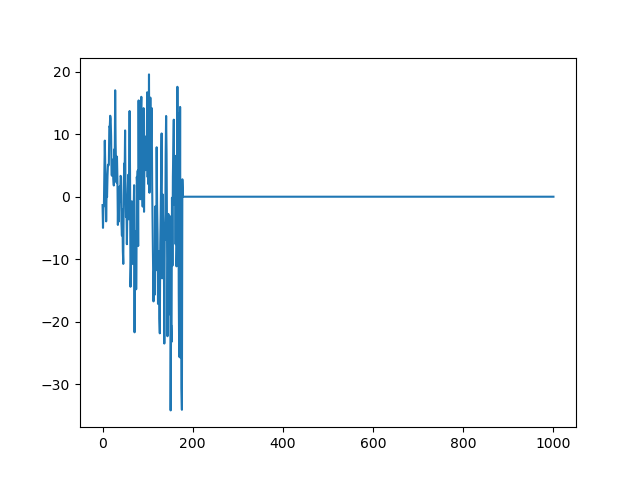

In [5]:
fn = "/sf/alvra/data/p18956/raw/scan_data/NiBDT_noLaser_monoscan_025/run_001160.BSDATA.h5"
f = SFDataFile(fn)
ch = f["SARFE10-PBPG050:HAMP-INTENSITY-CAL"]
vals = ch.data
plt.figure()
plt.plot(vals)


<IPython.core.display.Javascript object>


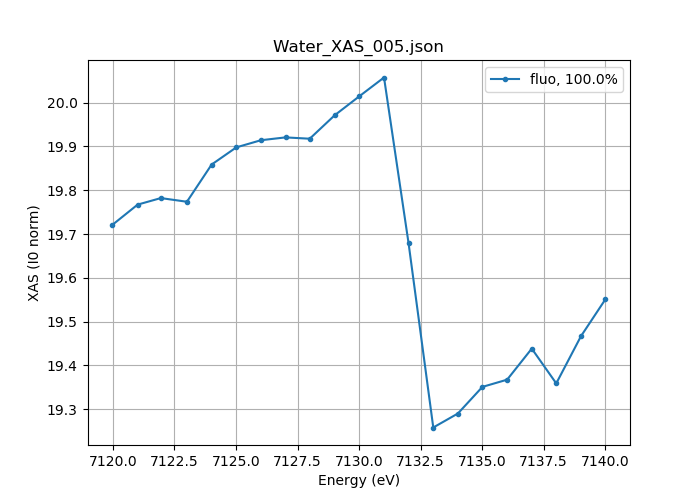

In [8]:
plt.figure(figsize = (7,5))

XAS1 = DataFluo[:,0]
err_low1 = DataFluo[:,1]
err_high1 = DataFluo[:,2]

XAS2 = DataFluo2[:,0]
err_low2 = DataFluo2[:,1]
err_high2 = DataFluo2[:,2]
plt.plot(Energy_eV, -XAS1, label='{}, {}%'.format('fluo', quantile_corr*100),marker='.')
#plt.plot(Energy_eV, -XAS2, label='{}, {}%'.format('trans', quantile_corr*100),marker='.', color='r')

#plt.fill_between(Energy_eV, err_low1, err_high1, color='lightblue')

#plt.plot(Energy_eV, (XAS2-XAS2[0])/sum(XAS2-XAS2[0]), label='{}, {}%'.format('APD2', quantile_corr*100),marker='.')
#plt.fill_between(Energy_eV, err_low2, err_high2, color='navajowhite')


plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.title(fc.selected_filename, fontsize=12)
plt.grid()

plt.show()

In [130]:
diff_024 = (XAS1-XAS1[0])/sum(XAS1-XAS1[0]) - (XAS2-XAS2[0])/sum(XAS2-XAS2[0])

<IPython.core.display.Javascript object>


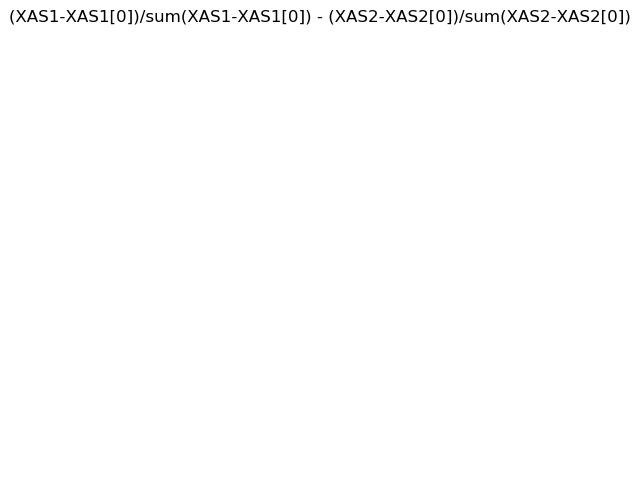

NameError: name 'diff_025' is not defined

In [132]:
plt.figure()
plt.suptitle('(XAS1-XAS1[0])/sum(XAS1-XAS1[0]) - (XAS2-XAS2[0])/sum(XAS2-XAS2[0])')
#plt.plot (Energy_eV,diff_024, label = 'diff scan_024')
plt.plot (Energy_eV,diff_025, label = 'diff scan_025')
plt.plot (Energy_eV,diff_026, label = 'diff scan_026')
plt.plot (Energy_eV,diff_028, label = 'diff scan_028')
plt.legend(loc='best')

plt.ylim(-0.01, 0.02)

plt.grid()
plt.show()

In [100]:
33.0339 + 9.11747

42.15137

## Load one step and check I0 filtering

In [12]:
filenumber = 31

channel_list = [channel_PIPS_fluo, channel_Izero122, channel_energy]

min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.8
######################################################

from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

step = scan[filenumber]
print (step)
results = load_data_compact(channel_list, step)
step.close()

IzeroFEL_shot = results[channel_Izero122]
DataFluo_shot = results[channel_PIPS_fluo]

IzeroFEL_raw = IzeroFEL_shot.copy()
DataFluo_shot_raw = DataFluo_shot.copy()

threshold_FEL = IzeroFEL_shot > min_I0
threshold_pump = DataFluo_shot > min_fluo

thresholds_filter = threshold_FEL & threshold_pump

DataFluo_shot = DataFluo_shot[thresholds_filter]
IzeroFEL_shot = IzeroFEL_shot[thresholds_filter]

DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
DataFluo_shot_norm_raw = DataFluo_shot_norm.copy()

med = np.median(DataFluo_shot_norm)
qnt_low = np.nanquantile(DataFluo_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_shot_norm, 0.5 + quantile_corr/2)

condition_corr_low = DataFluo_shot_norm > qnt_low
condition_corr_high = DataFluo_shot_norm < qnt_high

correlation_filter = condition_corr_low & condition_corr_high

DataFluo_shot_norm = DataFluo_shot_norm[correlation_filter]

print ("Original size:", len(DataFluo_shot_raw))
print ("Filtered size conditions:", len(DataFluo_shot))
print ("Filtered size correlation:", len(DataFluo_shot_norm))
print ("Energy = {} eV".format(Energy_eV[filenumber]))
print ("Median value Izero (filter) = {}".format(np.median(IzeroFEL_shot)))
print ("Median value fluo (filter) = {}".format(np.median(DataFluo_shot)))



Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18442/res/JF_pedestals/pedestal_20200201_2211.JF02T09V02.res.h5
jungfrau file: 01:10 02.02.2020
pedestal file: 22:23 01.02.2020
    mtime difference: 2:47:04.529115
SFDataFiles("/sf/alvra/data/p18442/raw/scan_data/Na2SO4_monoscan_2/run_002172.BSREAD.h5", "/sf/alvra/data/p18442/raw/scan_data/Na2SO4_monoscan_2/run_002172.JF02T09V02.h5"): 49 channels

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep 

<IPython.core.display.Javascript object>


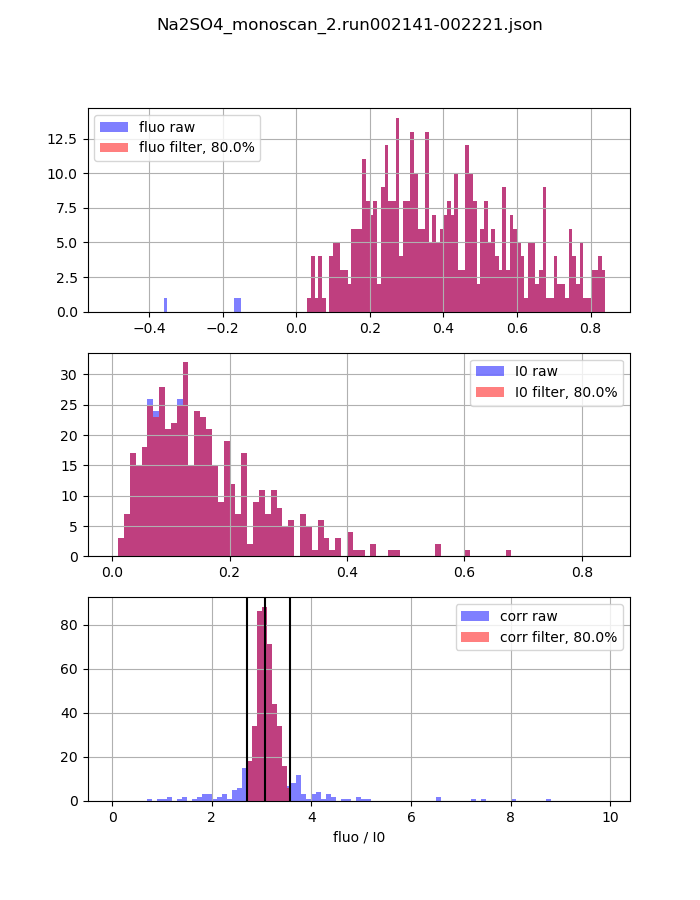

quantile range = 0.09999999999999998 0.9


In [13]:
plt.figure(figsize = (7,9))
plt.suptitle(fc.selected.split('/')[-1])

plt.subplot(311)
plt.hist(DataFluo_shot_raw, bins =np.arange(-0.5,0.85,0.01), facecolor='blue', label="fluo raw", alpha=0.5)
plt.hist(DataFluo_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="fluo filter, {}%".format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(312)
plt.hist(IzeroFEL_raw, bins =np.arange(0,0.85,0.01), facecolor='blue', label='I0 raw', alpha=0.5)
plt.hist(IzeroFEL_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label ='I0 filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(313)
x_axis = np.arange(0,10,0.1)
plt.hist(DataFluo_shot_norm_raw, bins =x_axis, facecolor='blue', label='corr raw', alpha=0.5)
plt.hist(DataFluo_shot_norm, bins =x_axis, facecolor='red', label='corr filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")
plt.axvline(med, color = 'k') 
plt.axvline(qnt_low, color = 'k')
plt.axvline(qnt_high, color = 'k') 
plt.xlabel('fluo / I0')

plt.show()
print ('quantile range = {}'.format(0.5 - quantile_corr/2), 0.5 + quantile_corr/2)

##  Check data distributions with quantiles 

In [22]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

channel_list = [channel_PIPS_fluo, channel_Izero122, channel_energy]

######################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

DataFluo = []

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    results = load_data_compact(channel_list, step)
    
    DataFluo_shot = results[channel_PIPS_fluo]
    IzeroFEL_shot = results[channel_Izero122]
    
    DataFluo_shot_norm = DataFluo_shot / IzeroFEL_shot
    
    df_fluo = pd.DataFrame(DataFluo_shot_norm)
    DataFluo.append(np.nanquantile(df_fluo, quantiles))
    
DataFluo = np.asarray(DataFluo)                  


print ("Job done!")

Step 81 of 81: Processing run_002221

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet           999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET          999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY         999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS 999 / 999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 999 / 999 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 50.0 Hz
Job done!


<IPython.core.display.Javascript object>


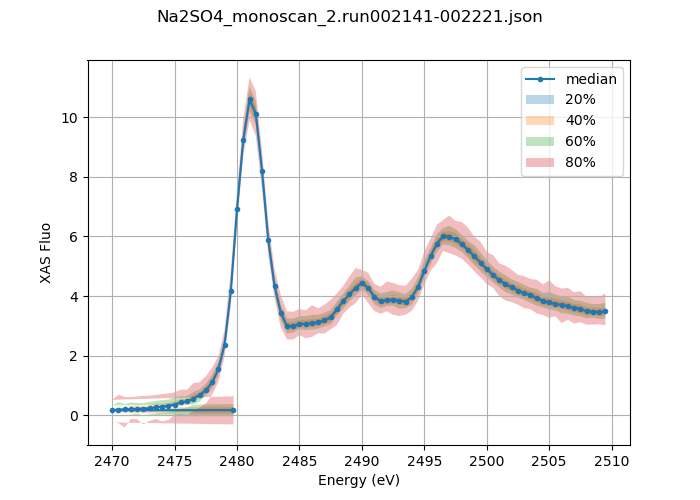

In [25]:
plt.figure(figsize = (7,5))
plt.suptitle(fc.selected.split('/')[-1])

plt.plot(Energy_eV, DataFluo[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(DataFluo[:,4]),np.array(DataFluo[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,3]),np.array(DataFluo[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,2]),np.array(DataFluo[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo[:,1]),np.array(DataFluo[:,8]), label='80%', alpha = 0.3)
plt.grid()

plt.legend(loc="best")
plt.ylabel("XAS Fluo")
plt.xlabel("Energy (eV)")

plt.show()

### Now choose thresholds and quantile